In [1]:
# !pip install firebase-admin

In [2]:
import os
import firebase_admin
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from firebase_admin import credentials, firestore
from datetime import datetime, timedelta
from dotenv import load_dotenv

# Firebase SDKの初期化（サービスアカウントJSONキーのパスを指定）
cred = credentials.Certificate("./smile-sync-firebase-service-account.json")
firebase_admin.initialize_app(cred)

# Firestoreクライアントを初期化
db = firestore.client()

### 1分ごとの笑顔時間の遷移

In [3]:
# コレクションとドキュメントへの参照
collection_name = "smilepoint_history"
document_name = "2024-09-02 08:18:14"
doc_ref = db.collection(collection_name).document(document_name)

# ドキュメントを取得
doc = doc_ref.get()
if doc.exists:
    smile_points_log = doc.to_dict().get('smile_points_log', [])
else:
    print(f"Document {document_name} not found in collection {collection_name}.")
    exit()

# データを確認
# print(smile_points_log[:5])  # データが取得されているか最初の5つを確認

In [4]:
# データフレームに変換
df = pd.DataFrame(smile_points_log)

# timestampをdatetime形式に変換
df['timestamp'] = pd.to_datetime(df['timestamp'])

# スタート時間を取得（最も古いtimestampをスタート時間とする）
start_time = df['timestamp'].min()

# 1分ごとにデータを集計
df['time_bucket'] = (df['timestamp'] - start_time).dt.total_seconds() // 60


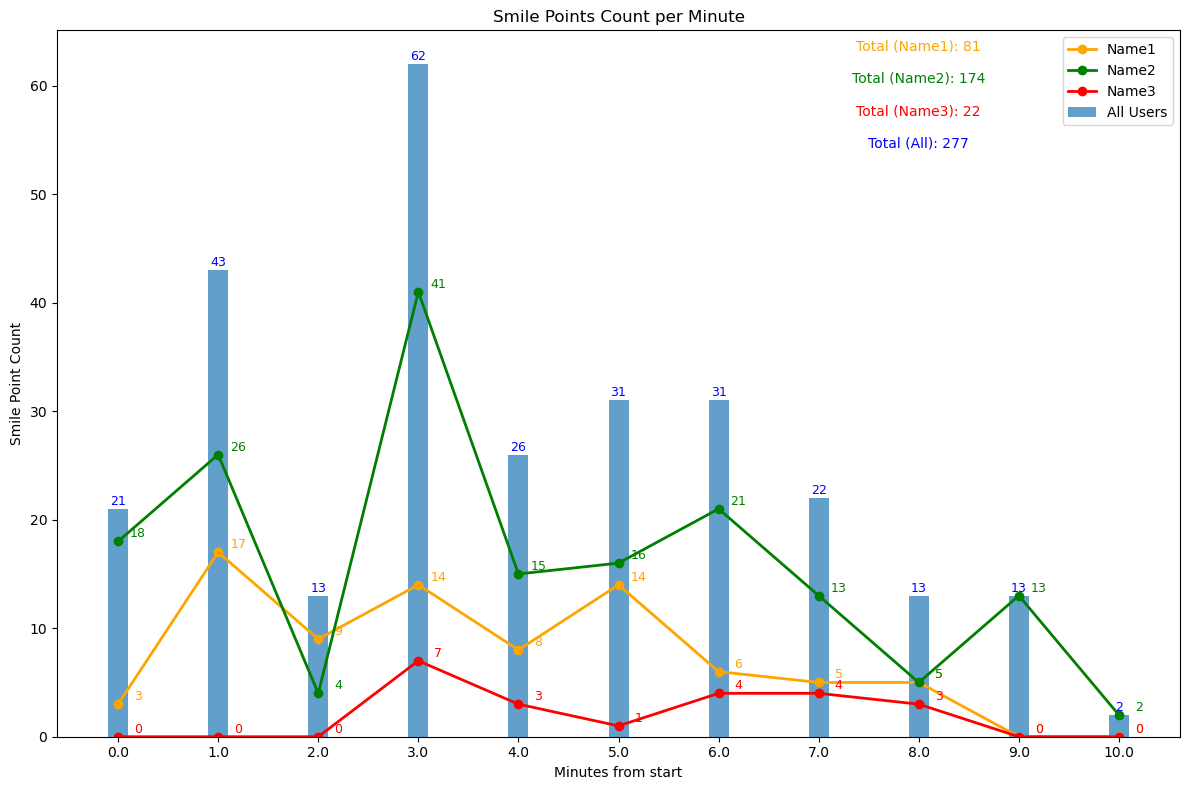

In [5]:
# .envから環境変数を読み込む
load_dotenv()
name1 = os.getenv("NICKNAME1")
name2 = os.getenv("NICKNAME2")
name3 = os.getenv("NICKNAME3")

# 特定の被験者のデータをフィルタリング
name1_df = df[df['nickname'] == name1]
name2_df = df[df['nickname'] == name2]
name3_df = df[df['nickname'] == name3]

# 1分ごとのカウントを計算
all_counts = df.groupby('time_bucket').size()
name1_counts = name1_df.groupby('time_bucket').size()
name2_counts = name2_df.groupby('time_bucket').size()
name3_counts = name3_df.groupby('time_bucket').size()

# グラフの作成準備（棒グラフの位置をずらすためにx軸の範囲を設定）
time_buckets = np.arange(len(all_counts))
bar_width = 0.2

# グラフを描画
plt.figure(figsize=(12, 8))

# 全員のカウント（棒グラフ）
plt.bar(time_buckets, all_counts.values, width=bar_width, label="All Users", align='center', alpha=0.7)

# 各被験者のカウント（折れ線グラフ）
plt.plot(time_buckets, name1_counts.reindex(all_counts.index, fill_value=0).values, label="Name1", color='orange', marker='o', linewidth=2)
plt.plot(time_buckets, name2_counts.reindex(all_counts.index, fill_value=0).values, label="Name2", color='green', marker='o', linewidth=2)
plt.plot(time_buckets, name3_counts.reindex(all_counts.index, fill_value=0).values, label="Name3", color='red', marker='o', linewidth=2)

# グラフの装飾
plt.xlabel("Minutes from start")
plt.ylabel("Smile Point Count")
plt.title("Smile Points Count per Minute")
plt.xticks(time_buckets, all_counts.index)

# 各バーの上に数値ラベルを追加
for i in range(len(all_counts)):
    plt.text(time_buckets[i], all_counts.values[i] + 0.1, str(all_counts.values[i]), ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(time_buckets[i] + 0.2, name1_counts.reindex(all_counts.index, fill_value=0).values[i] + 0.1, str(name1_counts.reindex(all_counts.index, fill_value=0).values[i]), ha='center', va='bottom', fontsize=9, color='orange')
    plt.text(time_buckets[i] + 0.2, name2_counts.reindex(all_counts.index, fill_value=0).values[i] + 0.1, str(name2_counts.reindex(all_counts.index, fill_value=0).values[i]), ha='center', va='bottom', fontsize=9, color='green')
    plt.text(time_buckets[i] + 0.2, name3_counts.reindex(all_counts.index, fill_value=0).values[i] + 0.1, str(name3_counts.reindex(all_counts.index, fill_value=0).values[i]), ha='center', va='bottom', fontsize=9, color='red')

# 各被験者の合計値を計算して表示
total_all = all_counts.sum()
total_name1 = name1_counts.sum()
total_name2 = name2_counts.sum()
total_name3 = name3_counts.sum()

plt.text(len(all_counts) - 3, max(all_counts) - 8, f"Total (All): {total_all}", ha='center', va='bottom', fontsize=10, color='blue')
plt.text(len(all_counts) - 3, max(all_counts) + 1, f"Total (Name1): {total_name1}", ha='center', va='bottom', fontsize=10, color='orange')
plt.text(len(all_counts) - 3, max(all_counts) - 2, f"Total (Name2): {total_name2}", ha='center', va='bottom', fontsize=10, color='green')
plt.text(len(all_counts) - 3, max(all_counts) - 5, f"Total (Name3): {total_name3}", ha='center', va='bottom', fontsize=10, color='red')

# 凡例を表示
plt.legend()

# グラフを表示
save_dir = os.getenv("SAVE_DIR")
plt.tight_layout()
plt.savefig(save_dir + 'smile_points_per_minute.png', dpi=300)
plt.show()

### 1分ごとのアイデア数の遷移

In [10]:
# ドキュメントを取得
doc = doc_ref.get()
if doc.exists:
    smile_ideas_log = doc.to_dict().get('smile_ideas_log', [])
else:
    print(f"Document {document_name} not found in collection {collection_name}.")
    exit()

[{'timestamp': DatetimeWithNanoseconds(2024, 9, 2, 8, 23, 59, 981848, tzinfo=datetime.timezone.utc), 'client_id': '154c988a-2bf6-4b6f-914d-9d563dbbfad0', 'smile_point': 10, 'total_smile_point': 0, 'nickname': 'Yosshy'}, {'smile_point': 10, 'client_id': '154c988a-2bf6-4b6f-914d-9d563dbbfad0', 'timestamp': DatetimeWithNanoseconds(2024, 9, 2, 8, 24, 2, 583573, tzinfo=datetime.timezone.utc), 'total_smile_point': 10, 'nickname': 'Yosshy'}, {'smile_point': 10, 'client_id': '154c988a-2bf6-4b6f-914d-9d563dbbfad0', 'timestamp': DatetimeWithNanoseconds(2024, 9, 2, 8, 24, 13, 489534, tzinfo=datetime.timezone.utc), 'total_smile_point': 20, 'nickname': 'Yosshy'}, {'smile_point': 10, 'client_id': '154c988a-2bf6-4b6f-914d-9d563dbbfad0', 'timestamp': DatetimeWithNanoseconds(2024, 9, 2, 8, 24, 21, 583763, tzinfo=datetime.timezone.utc), 'total_smile_point': 30, 'nickname': 'Yosshy'}, {'smile_point': 10, 'client_id': '154c988a-2bf6-4b6f-914d-9d563dbbfad0', 'timestamp': DatetimeWithNanoseconds(2024, 9, 2,

In [7]:
# データフレームに変換
df = pd.DataFrame(smile_ideas_log)

# timestampをdatetime形式に変換
df['timestamp'] = pd.to_datetime(df['timestamp'])

# スタート時間を取得（最も古いtimestampをスタート時間とする）
start_time = df['timestamp'].min()

# 1分ごとにデータを集計
df['time_bucket'] = (df['timestamp'] - start_time).dt.total_seconds() // 60


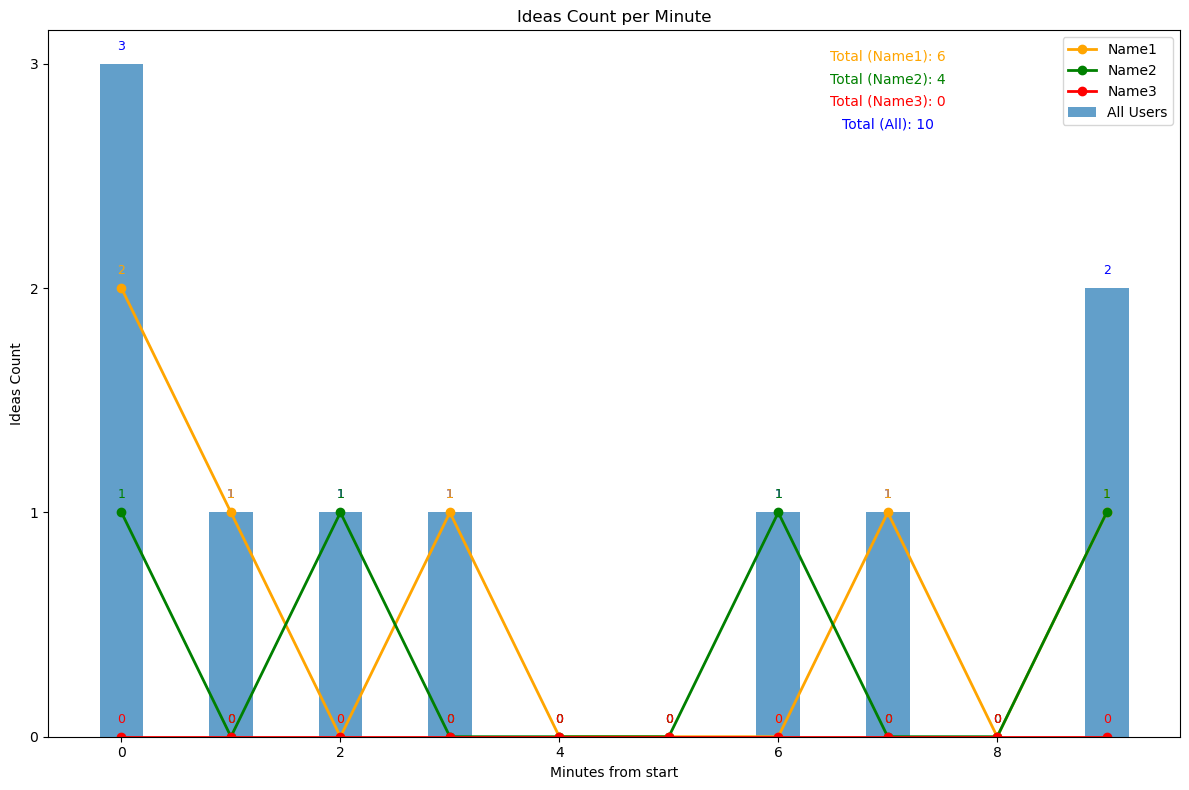

In [8]:
# 特定の被験者のデータをフィルタリング
name1_df = df[df['nickname'] == name1]
name2_df = df[df['nickname'] == name2]
name3_df = df[df['nickname'] == name3]

# 1分ごとのカウントを計算
all_counts = df.groupby('time_bucket').size()
name1_counts = name1_df.groupby('time_bucket').size()
name2_counts = name2_df.groupby('time_bucket').size()
name3_counts = name3_df.groupby('time_bucket').size()

# 全ての時間を網羅するインデックスを生成
time_buckets = np.arange(df['time_bucket'].min(), df['time_bucket'].max() + 1)

# グラフの描画
plt.figure(figsize=(12, 8))

# 全員のカウント（棒グラフ）
plt.bar(time_buckets, all_counts.reindex(time_buckets, fill_value=0).values, width=0.4, label="All Users", align='center', alpha=0.7)

# 各被験者のカウント（折れ線グラフ）
plt.plot(time_buckets, name1_counts.reindex(time_buckets, fill_value=0).values, label="Name1", color='orange', marker='o', linewidth=2)
plt.plot(time_buckets, name2_counts.reindex(time_buckets, fill_value=0).values, label="Name2", color='green', marker='o', linewidth=2)
plt.plot(time_buckets, name3_counts.reindex(time_buckets, fill_value=0).values, label="Name3", color='red', marker='o', linewidth=2)

# 縦軸のメモリを整数にする
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# グラフの装飾
plt.xlabel("Minutes from start")
plt.ylabel("Ideas Count")
plt.title("Ideas Count per Minute")

# 各データポイントの上に数値ラベルを追加
for i in range(len(time_buckets)):
    plt.text(time_buckets[i], all_counts.reindex(time_buckets, fill_value=0).values[i] + 0.05, 
             str(all_counts.reindex(time_buckets, fill_value=0).values[i]), ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(time_buckets[i], name1_counts.reindex(time_buckets, fill_value=0).values[i] + 0.05, 
             str(name1_counts.reindex(time_buckets, fill_value=0).values[i]), ha='center', va='bottom', fontsize=9, color='orange')
    plt.text(time_buckets[i], name2_counts.reindex(time_buckets, fill_value=0).values[i] + 0.05, 
             str(name2_counts.reindex(time_buckets, fill_value=0).values[i]), ha='center', va='bottom', fontsize=9, color='green')
    plt.text(time_buckets[i], name3_counts.reindex(time_buckets, fill_value=0).values[i] + 0.05, 
             str(name3_counts.reindex(time_buckets, fill_value=0).values[i]), ha='center', va='bottom', fontsize=9, color='red')

# 各被験者の合計値を計算して表示
total_all = all_counts.sum()
total_name1 = name1_counts.sum()
total_name2 = name2_counts.sum()
total_name3 = name3_counts.sum()

# 合計値の表示位置を調整
plt.text(len(time_buckets) - 3, max(all_counts) - 0.3, f"Total (All): {total_all}", ha='center', va='bottom', fontsize=10, color='blue')
plt.text(len(time_buckets) - 3, max(all_counts) - 0, f"Total (Name1): {total_name1}", ha='center', va='bottom', fontsize=10, color='orange')
plt.text(len(time_buckets) - 3, max(all_counts) - 0.1, f"Total (Name2): {total_name2}", ha='center', va='bottom', fontsize=10, color='green')
plt.text(len(time_buckets) - 3, max(all_counts) - 0.2, f"Total (Name3): {total_name3}", ha='center', va='bottom', fontsize=10, color='red')

# 凡例を表示
plt.legend()

# グラフを高解像度で保存
plt.tight_layout()
plt.savefig(save_dir + 'smile_ideas_per_minute.png', dpi=300)
plt.show()